In [11]:
import gymnasium as gym
import numpy as np
import torch
from utils import *
from dreamer import *
import pickle
from collections import namedtuple
import random
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_printoptions(threshold=2000, linewidth=200)
np.set_printoptions(threshold=2000, linewidth=200)

environmentName = "CarRacing-v3"
renderMode = None
numUpdates = 3000
initialNumEpisodes = 1 # How many episodes to play before first update
playInterval = 4   # How often to play an episode to gather new data
stepCountLimit = 256

env = gym.make(environmentName, render_mode=renderMode)
observationShape = torch.tensor(env.observation_space.shape)
actionSize = torch.tensor(env.action_space.shape) if hasattr(env.action_space, 'shape') else np.array([env.action_space.n])
print(f"Env {environmentName} with observations {observationShape} and actions {actionSize}\n###\n")
dreamer = Dreamer()

EpisodesBuffer = namedtuple('EpisodeBuffer', ['observations', 'actions', 'rewards'])
episodesBuffer = EpisodesBuffer(observations=[], actions=[], rewards=[])

worldModelLosses, reconstructionLosses, rewardPredictionLosses, klLosses, criticLosses, actorLosses, valueEstimates  = [], [], [], [], [], [], []

totalUpdates = 0
for i in range(-initialNumEpisodes, numUpdates):
    if i % playInterval == 0 or i < 0:
        observation, info = env.reset()
        observation = torch.from_numpy(np.transpose(observation, (2, 0, 1))).unsqueeze(0).to(device).float()/255.0
        observations, actions, rewards, dones = [observation], [], [], []
        stepCount, totalReward, done = 1, 0, False
        while not done:
            # action = env.action_space.sample()*[0.5, 5, 0.2] # For now random action, scaled so we go a bit forward
            action = dreamer.act(observation, True if stepCount == 1 else False)
            observation, reward, terminated, truncated, info = env.step(action.cpu().numpy())
            observation = torch.from_numpy(np.transpose(observation, (2, 0, 1))).unsqueeze(0).to(device).float()/255.0
            stepCount += 1
            done = terminated or truncated or stepCount >= stepCountLimit
            totalReward += reward
            
            observations.append(observation)
            actions.append(action)
            rewards.append(reward)
            # dones.append(done)
        # print(f"Total Reward: {totalReward:.4f}"
        
        episodesBuffer.observations.append(torch.stack(observations).squeeze(1))
        episodesBuffer.actions.append(torch.stack(actions).to(device))
        episodesBuffer.rewards.append(torch.tensor(rewards).view(-1, 1).to(device))

    episodeIndex = random.randint(0, len(episodesBuffer.observations) - 1)
    selectedEpisodeObservations = episodesBuffer.observations[episodeIndex]
    selectedEpisodeActions      = episodesBuffer.actions[episodeIndex]
    selectedEpisodeRewards      = episodesBuffer.rewards[episodeIndex]

    worldModelLoss, reconstructionLoss, rewardPredictionLoss, klLoss = dreamer.trainWorldModel(selectedEpisodeObservations, selectedEpisodeActions, selectedEpisodeRewards)
    criticLoss, actorLoss, valueEstimate = dreamer.trainActorCritic(selectedEpisodeObservations)
    worldModelLosses.append(worldModelLoss)
    reconstructionLosses.append(reconstructionLoss)
    rewardPredictionLosses.append(rewardPredictionLoss)
    klLosses.append(klLoss)
    criticLosses.append(criticLoss)
    actorLosses.append(actorLoss)
    valueEstimates.append(valueEstimate)

    if i % 10 == 0 and i >= 0:
        print(f"i {i:6}: worldModelLoss, criticLoss, actorLoss   = {worldModelLoss:.6f}, {criticLoss:.8f}, {actorLoss:.8f}")
env.close()

Env CarRacing-v3 with observations tensor([96, 96,  3]) and actions tensor([3])
###

i =      0
worldModelLoss   = 0.1156
criticLoss       = 0.6405
actorLoss        = -2.2650

i =     10
worldModelLoss   = 0.1002
criticLoss       = 0.3592
actorLoss        = -1.8888

i =     20
worldModelLoss   = 0.0785
criticLoss       = 0.3531
actorLoss        = -1.3970

i =     30
worldModelLoss   = 0.0641
criticLoss       = 0.6790
actorLoss        = -2.0099

i =     40
worldModelLoss   = 0.0633
criticLoss       = 0.8659
actorLoss        = -0.0860

i =     50
worldModelLoss   = 0.0617
criticLoss       = 1.1505
actorLoss        = 3.2713

i =     60
worldModelLoss   = 0.0504
criticLoss       = 0.3114
actorLoss        = 0.1935

i =     70
worldModelLoss   = 0.0549
criticLoss       = 0.1976
actorLoss        = 0.5818

i =     80
worldModelLoss   = 0.0492
criticLoss       = 0.1772
actorLoss        = -2.5068

i =     90
worldModelLoss   = 0.0775
criticLoss       = 2.1272
actorLoss        = 1.3193

i =    10

OutOfMemoryError: CUDA out of memory. Tried to allocate 72.00 MiB. GPU 0 has a total capacity of 6.00 GiB of which 0 bytes is free. Including non-PyTorch memory, this process has 17179869184.00 GiB memory in use. Of the allocated memory 16.77 GiB is allocated by PyTorch, and 1.77 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [12]:
import imageio.v2 as imageio
import torch

env = gym.make(environmentName, render_mode="rgb_array")
observation, info = env.reset()
observation = torch.from_numpy(np.transpose(observation, (2, 0, 1))).unsqueeze(0).to(device) / 255.0
done = False
fileName = "carTest"
fps = 30

# Initialize video writer
video_filename =  fileName + ".mp4"
with imageio.get_writer(video_filename, fps=fps) as video:
    while not done:
        action = dreamer.act(observation, reset=False)
        observation, reward, terminated, truncated, info = env.step(action.cpu().numpy())
        observation = torch.from_numpy(np.transpose(observation, (2, 0, 1))).unsqueeze(0).to(device) / 255.0
        done = terminated or truncated
        video.append_data(env.render())
env.close()


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x71f6e40] Warning: data is not aligned! This can lead to a speed loss


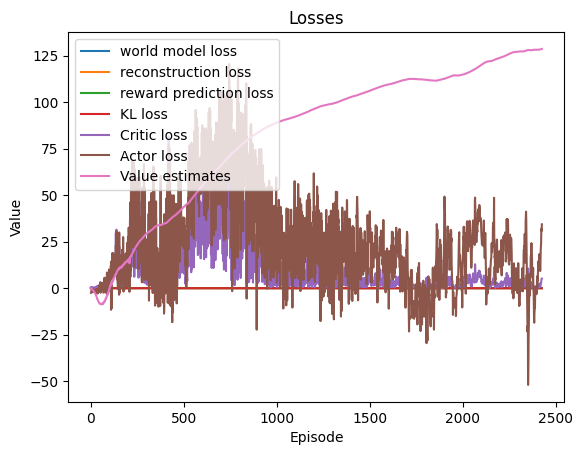

In [13]:
import matplotlib.pyplot as plt
plt.plot(worldModelLosses,          label="world model loss")
plt.plot(reconstructionLosses,      label="reconstruction loss")
plt.plot(rewardPredictionLosses,    label="reward prediction loss")
plt.plot(klLosses,                  label="KL loss")
plt.plot(criticLosses,              label="Critic loss")
plt.plot(actorLosses,               label="Actor loss")
plt.plot(valueEstimates,            label="Value estimates")
plt.legend()
plt.title("Losses")
plt.xlabel("Episode")
plt.ylabel("Value")
plt.show()

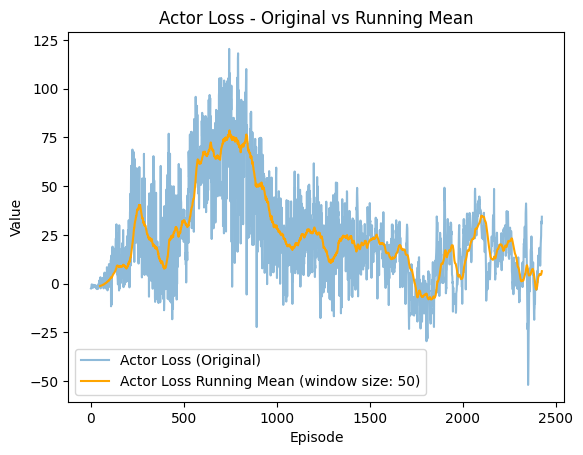

In [15]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate running mean
def running_mean(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

# Set a larger window size for clearer smoothing
window_size = 50  # Try increasing this value to see more smoothing

# Calculate running mean of the world model loss
world_model_running_mean = running_mean(actorLosses, window_size)

# Plot the original and smoothed world model loss
plt.plot(actorLosses, label="Actor Loss (Original)", alpha=0.5)
plt.plot(range(window_size - 1, len(actorLosses)), world_model_running_mean, 
         label=f"Actor Loss Running Mean (window size: {window_size})", color="orange")
plt.title("Actor Loss - Original vs Running Mean")
plt.xlabel("Episode")
plt.ylabel("Value")
plt.legend()
plt.show()


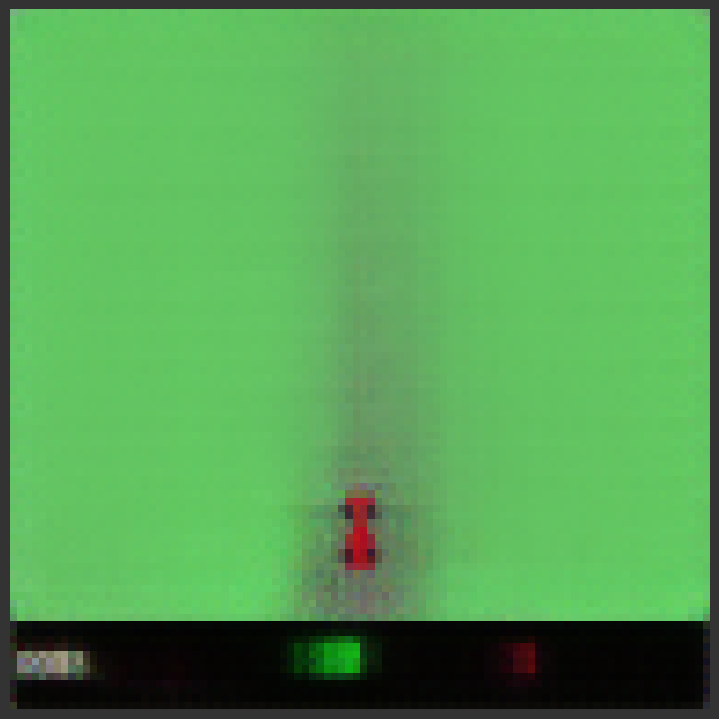

In [10]:
import tkinter as tk
from tkinter import ttk
from PIL import Image, ImageTk
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.figure import Figure

# Initialize your Dreamer model and device here
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the start image
start_image = np.array(Image.open("startImage2.png"))  # Replace with uploaded image path
start_image_tensor = torch.from_numpy(np.transpose(start_image, (2, 0, 1))).unsqueeze(0).to(device).float() / 255.0

# Initialize the rollout
recurrent_state, latent_state = dreamer.rolloutInitialize(start_image_tensor)

# Define dark mode colors
BG_COLOR = "#333333"
FG_COLOR = "#DDDDDD"
SLIDER_COLOR = "#555555"
SLIDER_THUMB_COLOR = "#AAAAAA"
BUTTON_COLOR = "#444444"
BUTTON_HOVER_COLOR = "#666666"

# GUI setup
root = tk.Tk()
root.title("Dreamer Rollout Interface")
root.configure(bg=BG_COLOR)
root.attributes('-fullscreen', True)  # Fullscreen mode
root.bind("<Escape>", lambda event: root.attributes("-fullscreen", False))  # Exit fullscreen with ESC

# Position window on primary monitor (top left corner)
root.geometry(f"{root.winfo_screenwidth()}x{root.winfo_screenheight()}+0+0")

# Styling configuration
style = ttk.Style()
style.theme_use('clam')
style.configure("TFrame", background=BG_COLOR)
style.configure("TLabel", background=BG_COLOR, foreground=FG_COLOR)
style.configure("TButton", background=BUTTON_COLOR, foreground=FG_COLOR, font=("Arial", 12), relief="flat", padding=8)
style.map("TButton", background=[("active", BUTTON_HOVER_COLOR)])

# Display for rollout images
fig, ax = plt.subplots(figsize=(7, 7))
fig.patch.set_facecolor(BG_COLOR)
ax.set_facecolor(BG_COLOR)
canvas = FigureCanvasTkAgg(fig, master=root)
canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=True, pady=(20, 10))

def update_observation_image(obs_image):
    ax.clear()
    ax.imshow(obs_image)
    ax.axis('off')
    canvas.draw()

# Frame for sliders positioned to the right and centered below the image
slider_frame = ttk.Frame(root)
slider_frame.pack(side=tk.TOP, pady=10)

action_labels = ["Steer", "Acceleration", "Brake"]
action_ranges = [(-1, 1), (0, 1), (0, 1)]
action = torch.tensor([0.0, 1.0, 0.0], dtype=torch.float32, device=device)
sliders = []

# Spacer to push sliders to the right
spacer = ttk.Frame(slider_frame, width=200, style="TFrame")
spacer.pack(side=tk.LEFT)

# Action sliders with custom ranges and names
for i in range(3):
    label = ttk.Label(slider_frame, text=action_labels[i], font=("Arial", 12, "bold"))
    label.pack(side=tk.LEFT, padx=(20, 10))

    slider = tk.Scale(slider_frame, from_=action_ranges[i][0], to=action_ranges[i][1], resolution=0.01, orient=tk.HORIZONTAL,
                      length=300, bg=BG_COLOR, fg=FG_COLOR, troughcolor=SLIDER_COLOR, sliderrelief="flat",
                      highlightthickness=0, activebackground=SLIDER_THUMB_COLOR)
    slider.set(action[i].item())
    slider.pack(side=tk.LEFT, padx=(0, 20))
    sliders.append(slider)

# Step function
def step():
    global recurrent_state, latent_state, action
    action_values = [slider.get() for slider in sliders]
    action = torch.tensor(action_values, dtype=torch.float32, device=device)
    
    # Rollout step
    next_recurrent_state, next_latent_state, next_observation, next_reward = dreamer.rolloutStep(
        recurrent_state, latent_state, action
    )
    recurrent_state, latent_state = next_recurrent_state, next_latent_state

    # Convert observation to image and display
    obs_image = next_observation.squeeze().permute(1, 2, 0).cpu().numpy()
    obs_image = np.clip(obs_image * 255, 0, 255).astype(np.uint8)
    update_observation_image(obs_image)

# Close (X) button in the top right corner
close_button = ttk.Button(root, text="X", command=root.destroy, style="TButton")
close_button.place(relx=0.98, rely=0.02, anchor="ne")  # Position in top-right corner

# Step button below sliders
step_button = ttk.Button(root, text="Step", command=step, style="TButton")
step_button.pack(side=tk.TOP, pady=20)

# Initial display
update_observation_image(start_image)

# Run GUI
root.mainloop()


In [ ]:
original = np.transpose(selectedEpisodeObservations.cpu()[1:], (0, 2, 3, 1))
reconstructed = np.transpose((dreamer.reconstructObservations(selectedEpisodeObservations, selectedEpisodeActions).cpu()), (0, 2, 3, 1))
i = 50
displayImage(np.concatenate((original[i], reconstructed[i]), 1))

In [ ]:
displayImage(np.transpose(selectedEpisodeObservations.cpu()[0], (1, 2, 0)))
saveImage(np.transpose((selectedEpisodeObservations[0].cpu().numpy()*255).astype(np.uint8), (1, 2, 0)), "startImage2.png")

In [ ]:
from PIL import Image
import numpy as np
startImage = np.array(Image.open("startImage.png"))
recurrentState, latentState = dreamer.rolloutInitialize(torch.from_numpy(np.transpose(startImage, (2, 0, 1))).unsqueeze(0).to(device).float()/255.0)
nextRecurrentState, nextLatentState, nextObservation, nextReward = dreamer.rolloutStep(recurrentState, latentState, torch.tensor([0, 1, 0], dtype=torch.float32, device=device))